# Introduction

One way of generating a neutral time series is considering a lattice of N individuals on which every time step one individual is replaced by another. Each individual of the lattice has an equal probability of being replaced (probability is $1/N$). The disappearance of the 1rst species can be interpreted as the result of either death or emigration. The replacing individual is either the result of immigration or growth. The probability of immigration depends on the immigration rate ($0 \leq \lambda \leq 1$). In case of an immigration event, all species of the external species pool $S$ have an equalprobability of immigrating. The probability of a growth event is thus given by the remaining $1 - \lambda$. Incase of growth, every individual has an equal probability of growing. Time series generated in this way depend on three variables: the length of the simulation time $T$, the immigration probability $\lambda$ and the number of individuals $N$. We study the effect of these three variables on both neutrality measures.

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [2]:
from timeseries_plotting import PlotTimeseries
from noise_properties_plotting import PiecewiseNormalize
from enum import Enum

## Settings figures

In [3]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

## Figure neutrality

In [4]:
class NeutralityTest(Enum):
    KULLBACKLEIBLER = 1
    COVARIANCE = 2


def plot_neutrality(f, type=NeutralityTest.KULLBACKLEIBLER, ax=0, ax_clb=0):
    if isinstance(f, str):
        df = pd.read_csv(f, index_col=0)
    elif isinstance(f, list):  # average of all files
        df = pd.DataFrame(np.nanmedian([pd.read_csv(fi, index_col=0).values for fi in f], axis=0),
                          columns=pd.read_csv(f[0], index_col=0).columns,
                          index=pd.read_csv(f[0], index_col=0).index)
        df[df == np.inf] = 1e4

    if ax == 0:
        fig = plt.figure()

        gs = gridspec.GridSpec(1, 2, width_ratios=[9, 1], wspace=0.3)

        ax = fig.add_subplot(gs[0])
        ax_clb = fig.add_subplot(gs[1])

    ax.set_facecolor('lightgrey')

    if type == NeutralityTest.KULLBACKLEIBLER:
        vmin = -1
        vmax = 3
        with np.errstate(divide='ignore'):
            log_KL = np.log10(df.T)
        mat = ax.matshow(log_KL, origin='lower', cmap='Blues_r',
                         aspect='auto', vmin=vmin, vmax=vmax)
    elif type == NeutralityTest.COVARIANCE:
        vmin = -5
        vmax = 0  # pvalue is max 1 = 1e0
        norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
        with np.errstate(divide='ignore'):
            log_nct = np.log10(df.T)
        mat = ax.matshow(log_nct, origin='lower', norm=norm,
                         cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)

    skiplabel = 0

    ax.set_xticks(range(0, df.shape[0], (skiplabel+1)))
    ax.set_xticklabels(['%d' % i for i in df.index][::(skiplabel+1)])
    ax.set_yticks(range(0, df.shape[1], (skiplabel+1)))
    ax.set_yticklabels(
        ['%.3f' % i for i in df.columns.astype(float)][::(skiplabel+1)])
    ax.set_xlabel('Size community')
    ax.set_ylabel(r'Immigration probability $\lambda$')

    if ax_clb != 0:
        plt.colorbar(mat, cax=ax_clb)

        if type == NeutralityTest.KULLBACKLEIBLER:
            ax_clb.set_title(r'log$_{10}$(D$_{KL}$)')

            ax_clb2 = ax_clb.twinx()
            ax_clb2.yaxis.set_ticks_position('right')
            ax_clb.yaxis.set_ticks_position('left')
            ax_clb2.yaxis.set_ticks([0.05, 0.95])
            ax_clb2.set_ylim([0, 1])
            ax_clb2.yaxis.set_ticklabels(['neutral', 'niche'])

        elif type == NeutralityTest.COVARIANCE:
            ax_clb.set_title(r'log$_{10}$($p_{NCT}$)')
            ax_clb2 = ax_clb.twinx()
            ax_clb2.yaxis.set_ticks_position('right')
            ax_clb.yaxis.set_ticks_position('left')
            ax_clb2.yaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                                     1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
            ax_clb2.set_ylim([0, 1])
            ax_clb2.yaxis.set_ticklabels(['niche', 'neutral'])

# Generating neutral timeseries

In [5]:
new = False

lamda = 0.01  # immigration probability

T = int(1e7)
tskip = 999

S = 50  # amount of different species
J = 5000  # Number of individuals in the community

f = 'test_neutral4.txt'


def neutral_timeseries(S, lamda, J, tskip=1e3, T=int(1e6), f=0):
    initcond = np.arange(J/S, J+1, J/S)

    x = np.copy(initcond)
    x_ts = np.copy(initcond)

    # save x as cumulative distribution, it makes simulations faster

    for i in range(T):
        if i % 1e6 == 0:
            print(i)

        if np.random.uniform(0, 1) < lamda:  # immigration from outside pool
            immi = int(np.random.uniform()*S)
            x[immi:] += 1
        else:
            growing = int(np.random.uniform()*J)

            x[x > growing] += 1

        dead = int(np.random.uniform()*(J+1))

        x[x > dead] -= 1

        if i % (tskip + 1) == 0:
            x_ts = np.vstack((x_ts, x))

    # transform cumulative distribution into abundances

    for i in range(1, S):
        x_ts[:, -i] = x_ts[:, -i] - x_ts[:, -i-1]

    if f != 0:
        np.savetxt(f, x_ts, fmt='%d')

    return x_ts


if new:
    neutral_timeseries(S, lamda, J, tskip, T, f)

Plot some neutral timeseries.

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


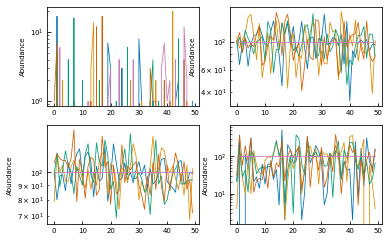

In [6]:
fig = plt.figure()

for i, l in enumerate(['', '2', '3', '4'], start=1):
    ax = fig.add_subplot(2, 2, i)
    ts_np = np.loadtxt('results/neutral_timeseries/ts_neutral' + l + '.txt').T
    ts = pd.DataFrame(
        ts_np, columns=['species_%d' % i for i in range(1, ts_np.shape[1]+1)])
    ts['time'] = range(len(ts))

    PlotTimeseries(ts, ax=ax)
plt.show()

Calculate neutrality measures for timeseries.

In [7]:
def neutral_measures(fKL, fNCT,
                     Js=[50, 100, 500, 1000, 2500, 5000],
                     lamdas=[0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]):
    KL = np.zeros([len(Js), len(lamdas)])
    NCT = np.zeros([len(Js), len(lamdas)])

    for i, J in enumerate(Js):
        for j, lamda in enumerate(lamdas):
            print(J, lamda)

            x_ts = neutral_timeseries(S, lamda, J, tskip=0, T=int(1e4))

            KL[i, j] = KullbackLeibler_neutrality(x_ts[:, :-1])

            for k in range(len(x_ts)):
                s = sum(x_ts[k])
                if s > 0:
                    x_ts[k] /= s

            NCT[i, j] = neutral_covariance_test(
                x_ts, ntests=500, method='Kolmogorov')

    KL = pd.DataFrame(KL, index=Js, columns=lamdas)
    KL.to_csv(fKL)

    NCT = pd.DataFrame(NCT, index=Js, columns=lamdas)
    NCT.to_csv(fNCT)

    return KL, NCT

Plot the neutrality measures.

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


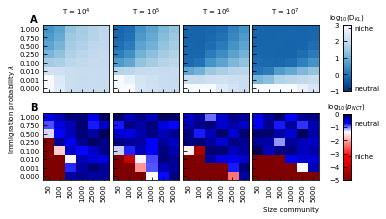

In [8]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3))

gs = gridspec.GridSpec(2, 4, wspace=0.05, hspace=0.3,
                       right=0.82, bottom=0.18, top=0.9)
gs_clb = gridspec.GridSpec(2, 1, hspace=0.35, top=0.9,
                           bottom=0.18, left=0.88, right=0.9)
gs_tot = gridspec.GridSpec(1, 1, top=0.95, bottom=0.08, left=0.07, right=0.82)

ax_clb_KL = fig.add_subplot(gs_clb[0])
ax_clb_NCT = fig.add_subplot(gs_clb[1])

for i, s in enumerate(['1e4', '1e5', '1e6', '1e7']):
    ax_KL = fig.add_subplot(gs[0, i])
    ax_NCT = fig.add_subplot(gs[1, i])

    ax_KL.set_title('T = 10$^{%d}$' % int(s[-1]))

    path = 'results/neutral_timeseries/'
    if i == 0:
        plot_neutrality([path + 'KL-%s-' % s + '%d.csv' % j for j in range(0, 6)],
                        ax=ax_KL, ax_clb=ax_clb_KL)
        plot_neutrality([path + 'NCT-%s-' % s + '%d.csv' % j for j in range(0, 6)],
                        type=NeutralityTest.COVARIANCE,
                        ax=ax_NCT, ax_clb=ax_clb_NCT)

        ax_KL.tick_params(axis="both", bottom=True, labelbottom=False, top=False, labeltop=False,
                          left=True, labelleft=True)
        ax_NCT.tick_params(axis="both", bottom=True, labelbottom=True, top=False, labeltop=False,
                           left=True, labelleft=True)

        ax_KL.text(-0.08, 1.15, 'A', transform=ax_KL.transAxes,
                   fontsize=10, fontweight='bold', va='top', ha='right')
        ax_NCT.text(-0.08, 1.15, 'B', transform=ax_NCT.transAxes,
                    fontsize=10, fontweight='bold', va='top', ha='right')

    else:
        plot_neutrality([path + 'KL-%s-' % s + '%d.csv' % j for j in range(0, 6)],
                        ax=ax_KL)
        plot_neutrality([path + 'NCT-%s-' % s + '%d.csv' % j for j in range(0, 6)],
                        type=NeutralityTest.COVARIANCE,
                        ax=ax_NCT)

        ax_KL.tick_params(axis="both", bottom=True, labelbottom=False, top=False, labeltop=False,
                          left=True, labelleft=False)
        ax_NCT.tick_params(axis="both", bottom=True, labelbottom=True, top=False, labeltop=False,
                           left=True, labelleft=False)

    ax_NCT.tick_params(axis='x', rotation=90)

    ax_KL.set_xlabel('')
    ax_NCT.set_xlabel('')
    ax_KL.set_ylabel('')
    ax_NCT.set_ylabel('')

ax = fig.add_subplot(gs_tot[0], frameon=False)
ax.tick_params(axis="both", bottom=False, labelbottom=False,
               left=False, labelleft=False)
ax.set_xlabel('Size community', x=1, ha='right')
ax.set_ylabel('Immigration probability $\lambda$')

plt.show()